In [2]:
import sklearn

In [61]:
from sklearn.isotonic import IsotonicRegression
import pandas as pd
from sklearn.metrics import brier_score_loss
from pathlib import Path
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

def get_calibration_model(path):
    # Get results df
    name = "results_.csv"
    results_df = pd.read_csv(Path("../../evaluation/05_results") / path / name)

    # Extract information about true positives vs false postives and plot calibration curve
    all_true = []
    all_predicted = []
    id_cols = sorted([col for col in results_df.columns if col.startswith("id_")])
    for id_col in id_cols[:-1]:
        id = int(id_col.split("_")[1])
        y_true = results_df[f"id_{id}"] == results_df[f"id_{id+1}"]
        y_prob = results_df[f"p{id}_{id+1}"].to_numpy()
        all_predicted = all_predicted + y_prob.tolist()
        all_true = all_true + y_true.tolist()

    model = IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip", increasing="auto")
    model.fit(all_predicted, all_true)

    return model


In [80]:
def plot_calibration(path, calibration_model):
    # Prepare fig
    fig, ax = plt.subplots(figsize=(8, 6))

    # Get results df
    name = "results_.csv"
    results_df = pd.read_csv(Path("../../evaluation/05_results") / path / name)

    # Extract information about true positives vs false postives and plot calibration curve
    all_true = []
    all_predicted = []
    id_cols = sorted([col for col in results_df.columns if col.startswith("id_")])
    for id_col in id_cols[:-1]:
        id = int(id_col.split("_")[1])
        y_true = results_df[f"id_{id}"] == results_df[f"id_{id+1}"]
        y_prob = results_df[f"p{id}_{id+1}"].to_numpy()

        # # Calibrate
        if  calibration_model is not None:
            y_prob = calibration_model.transform(y_prob)

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_prob, n_bins=15, strategy="quantile"
        )

        print(f'{id}-{id+1}', brier_score_loss(y_true, y_prob))
        all_predicted = all_predicted + y_prob.tolist()
        all_true = all_true + y_true.tolist()
        ax.plot(mean_predicted_value, fraction_of_positives, label=f"{id}-{id+1}")

    # Get total brier score
    print("Total brier score:", brier_score_loss(all_true, all_predicted))

    # Get counts in bins
    counts, bins = np.histogram(all_predicted, bins=15)

    # Plot perfect calibration line
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    # Normalize
    counts = (15/10)*counts / len(all_predicted)

    # plot
    ax.plot(bins[1:], counts, label="Probability Distribution", linestyle="--", color="grey")
    ax.fill_between(bins[1:], counts, 0, color='grey', alpha=.1)

    # Add legend and save plot
    ax.set_ylabel("Accuracy", fontsize=17)
    ax.set_xlabel("Decision Threshold", fontsize=17)

    # Make ticks smaller
    ax.tick_params(axis='both', which='both', labelsize=14)

    # Put probability distribution label for last plot on top
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[-2:] + handles[:-2]
    labels = labels[-2:] + labels[:-2]

    ax.legend(handles, labels, fontsize=13, loc="upper left")

    ax.set_title(f"Calibration Plot", fontweight="bold")


    fig.savefig("calibration_plot.png")


0-1 0.08542624448078497
1-2 0.06399433524121015
2-3 0.05762881030253475
3-4 0.0760795928045789
4-5 0.06907196075224857
5-6 0.059880982011447266
6-7 0.060352856909239576
Total brier score: 0.06749068321457774


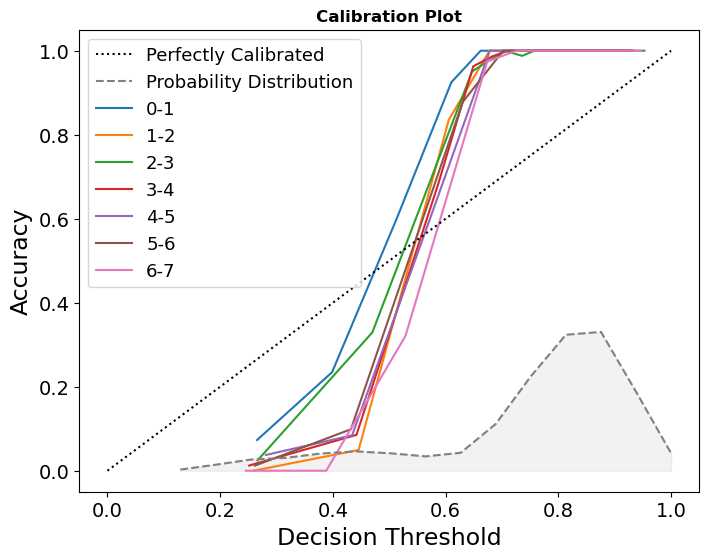

In [81]:
xxl_calibration_model = get_calibration_model("xxl_mvt_test")
plot_calibration("xxl_mvt_test", calibration_model=None)

0-1 0.04218718747736854
1-2 0.01106960290102676
2-3 0.013924489075847542
3-4 0.0227320910265638
4-5 0.017858243688055324
5-6 0.010646028448727451
6-7 0.009423648784753215
Total brier score: 0.01826304162890609


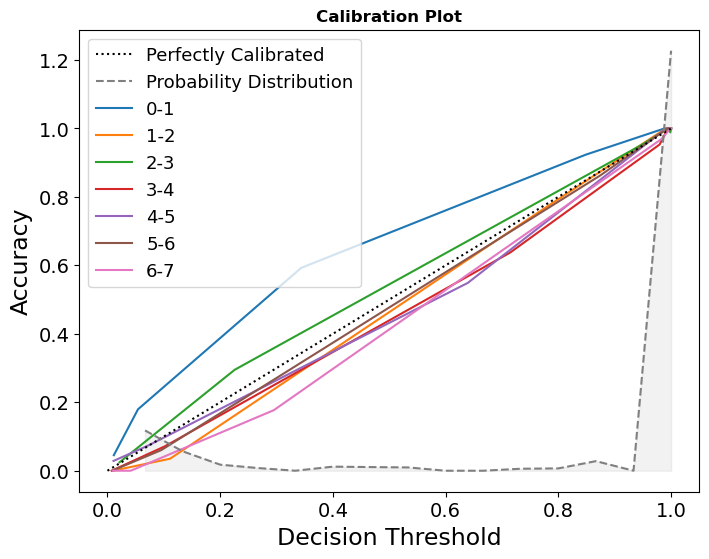

In [82]:
xxl_calibration_model = get_calibration_model("xxl_mvt_test")
plot_calibration("xxl_mvt_test", calibration_model=xxl_calibration_model)

0-1 0.008549885681946803
1-2 0.0014930073571024348
2-3 0.0014187549518958702
3-4 0.004133971137521225
4-5 0.001884007923033391
5-6 0.0033419417091114893
6-7 0.001764397849462367
Total brier score: 0.0032265666585819396


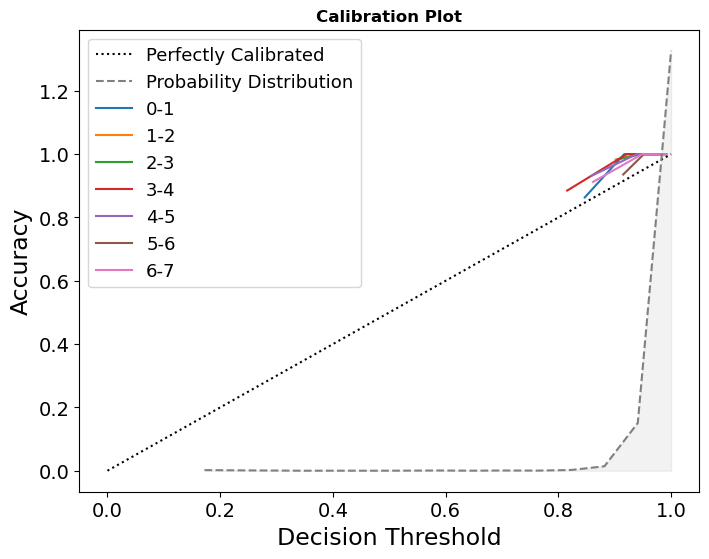

In [83]:
calibration_model = get_calibration_model("medium_mvt_test")
plot_calibration("medium_mvt_test", calibration_model=None)

0-1 0.005802908818401324
1-2 0.00017645155940525226
2-3 8.618986916944829e-05
3-4 0.0013140670609744867
4-5 9.821422295146283e-05
5-6 0.0018736439509103508
6-7 0.0004277297806517961
Total brier score: 0.00139702932320916


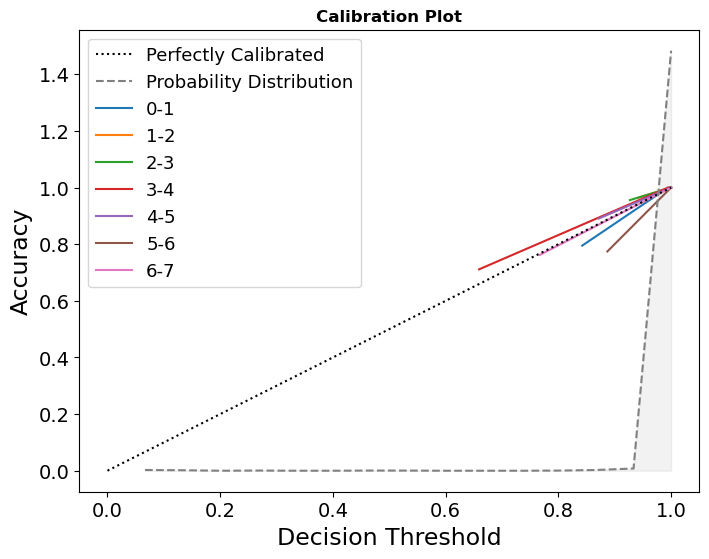

In [84]:
calibration_model = get_calibration_model("medium_mvt_test")
plot_calibration("medium_mvt_test", calibration_model=calibration_model)

0-1 0.005802908818401324
1-2 0.00017645155940525226
2-3 8.618986916944829e-05
3-4 0.0013140670609744867
4-5 9.821422295146283e-05
5-6 0.0018736439509103508
6-7 0.0004277297806517961
Total brier score: 0.00139702932320916


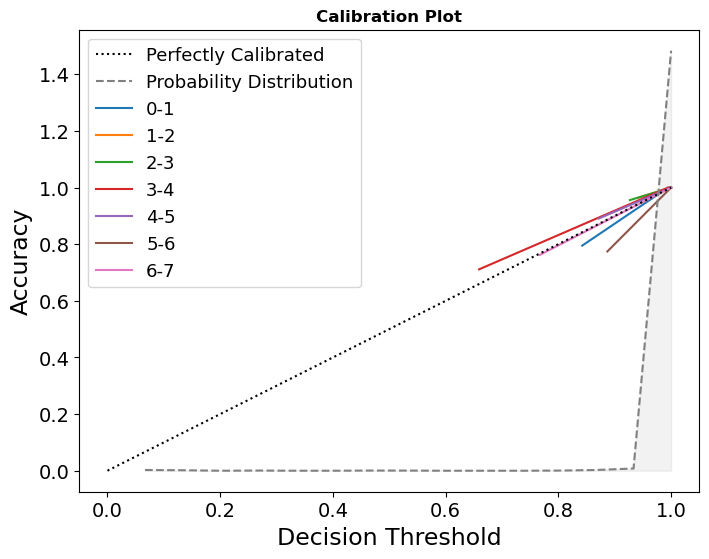

In [ ]:
calibration_model = get_calibration_model("medium_mvt_test")
plot_calibration("medium_mvt_test", calibration_model=calibration_model)

0-1 0.11226992734822541
1-2 0.04023907583620949
2-3 0.03588401970435706
3-4 0.13381885522577597
4-5 0.07033261727834801
5-6 0.06692323515244682
6-7 0.05589794788094791
Total brier score: 0.07362366834661581


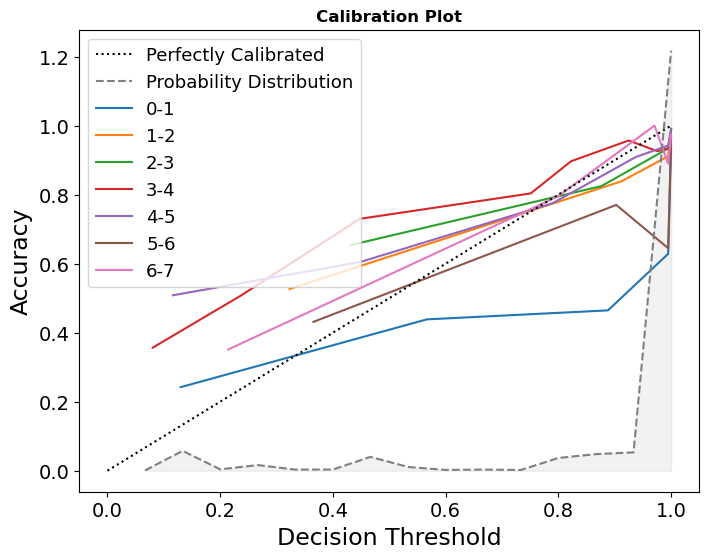

In [85]:
calibration_model = get_calibration_model("medium_mvt_test")
plot_calibration("small_mvt_test", calibration_model=calibration_model)

0-1 0.10977262805224304
1-2 0.03582796252129472
2-3 0.03179765133446905
3-4 0.11347206019307211
4-5 0.05941596706416809
5-6 0.061339550255536626
6-7 0.05486482623509369
Total brier score: 0.06664152080798247


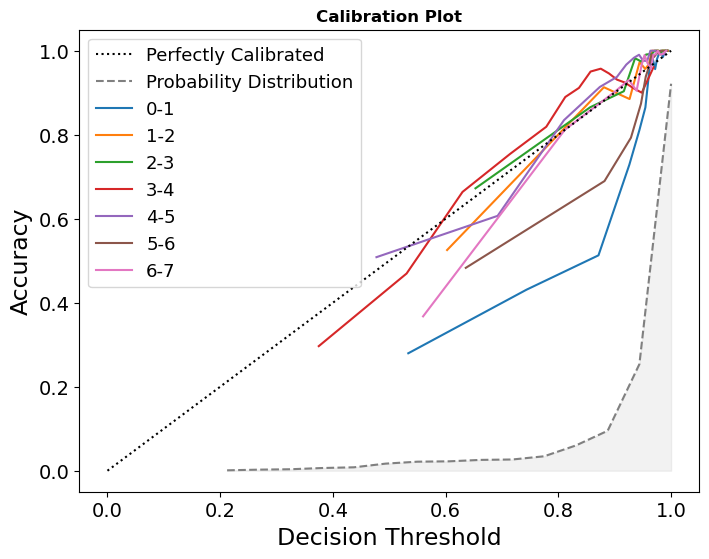

In [86]:
calibration_model = get_calibration_model("medium_mvt_test")
plot_calibration("small_mvt_test", calibration_model=None)

0-1 0.011652362269726877
1-2 0.002962941364795574
2-3 0.0031134956081275973
3-4 0.004031039091245087
4-5 0.002507617518462437
5-6 0.0046022318920974125
6-7 0.004939221731205679
Total brier score: 0.004829844210808666


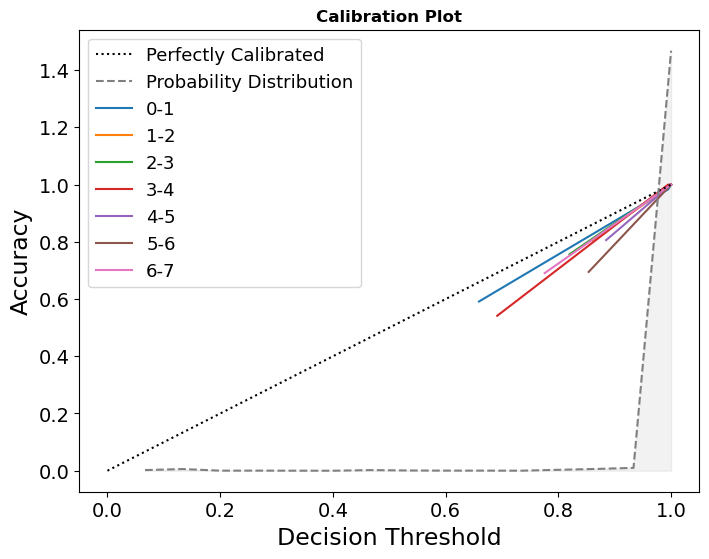

In [88]:
calibration_model = get_calibration_model("medium_mvt_test")
plot_calibration("large_mvt_test", calibration_model=calibration_model)

0-1 0.04227286447520184
1-2 0.023324956747404844
2-3 0.0278844152249135
3-4 0.032155936562860435
4-5 0.03415522606689735
5-6 0.03476271164936563
6-7 0.02945193310265283
Total brier score: 0.03200114911847092


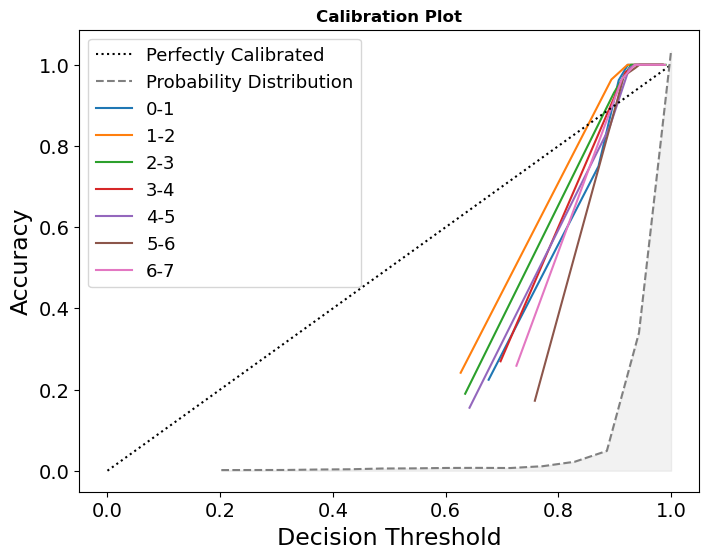

In [93]:
plot_calibration("xxl_mvt_test", calibration_model=None)

0-1 0.02713671354176911
1-2 0.009957769509832333
2-3 0.012921664061264123
3-4 0.019710290740805613
4-5 0.01633600677142508
5-6 0.014851846335210798
6-7 0.015944542172185532
Total brier score: 0.016694119018927513


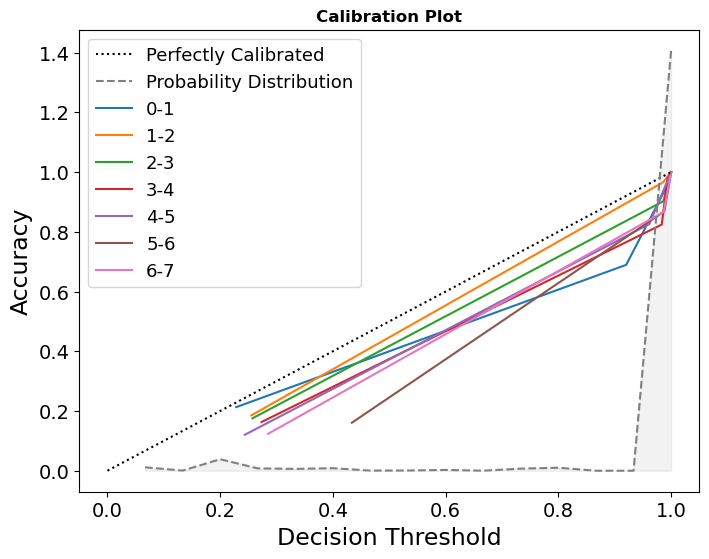

In [92]:
calibration_model = get_calibration_model("large_mvt_test")
plot_calibration("xxl_mvt_test", calibration_model=calibration_model)

In [ ]:
calibration_model = get_calibration_model("xxl_mvt_test")
plot_calibration("xxl_mvt_test", calibration_model=calibration_model)